In [18]:
from langgraph.graph import END, START, StateGraph
from typing import TypedDict
import base64
from pathlib import Path
from openai import OpenAI
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.checkpoint.memory import InMemorySaver
import json
from datetime import datetime
from PIL import Image
from IPython.display import display

# Initialize clients
client = OpenAI()
llm = init_chat_model("openai:gpt-4o-mini")
memory = InMemorySaver()

# State definition
class State(TypedDict):
    image_paths: list[str]
    detailed_prompts: list[dict]  # Replaced each iteration, not accumulated
    composite_prompt: dict
    synthetic_score: float
    image_score: float
    feedback_for_improvement: str
    iteration: int
    max_iterations: int
    best_composite_prompt: dict
    best_synthetic_score: float
    best_image_score: float
    final_image_path: str


In [19]:
# Helper functions

def load_images_from_folder(folder_path: str = "./images") -> list[str]:
    """Load all image file paths from the specified folder."""
    folder = Path(folder_path)
    if not folder.exists():
        raise ValueError(f"Folder {folder_path} does not exist")
    
    image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.webp'}
    image_paths = [
        str(p) for p in folder.iterdir() 
        if p.suffix.lower() in image_extensions
    ]
    
    if not image_paths:
        raise ValueError(f"No images found in {folder_path}")
    
    print(f"Found {len(image_paths)} image(s): {image_paths}")
    return sorted(image_paths)


def encode_image_to_base64(image_path: str) -> str:
    """Encode an image file to base64 string."""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')


def generate_per_image_prompt(image_path: str, feedback: str = "") -> dict:
    """Generate a detailed visual prompt for a single image using vision LLM."""
    
    # Encode image to base64 for LangChain
    base64_image = encode_image_to_base64(image_path)
    
    # Build prompt
    system_prompt = """You are an expert visual analyst. Analyze the provided image and generate a detailed visual prompt that captures all key visual characteristics.

Your response must be a JSON object with the following structure:
{
    "main_visual_elements": "Detailed description of main visual elements",
    "color_scheme": "Description of colors, tones, and palette",
    "text_overlay": "Description of any text or 'none' if not applicable",
    "overall_composition": "Description of layout, framing, perspective",
    "style_and_mood": "Description of artistic style and emotional mood"
}

Be thorough and specific. Include all important visual details."""
    
    user_prompt = f"""Analyze this image and generate a detailed visual prompt.

{f'Previous feedback to incorporate: {feedback}' if feedback else ''}

Image: {image_path}"""
    
    # Use LangChain LLM with vision support (using base64-encoded image)
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(
            content=[
                {"type": "text", "text": user_prompt},
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
            ]
        )
    ]
    
    response = llm.invoke(messages)
    
    # Parse response - LangChain returns content as string
    content = response.content if hasattr(response, 'content') else str(response)
    
    try:
        prompt_data = json.loads(content)
    except json.JSONDecodeError:
        # Try to extract JSON from markdown code blocks
        import re
        json_match = re.search(r'```(?:json)?\s*(\{.*?\})\s*```', content, re.DOTALL)
        if json_match:
            prompt_data = json.loads(json_match.group(1))
        else:
            raise ValueError(f"Could not parse JSON from LLM response: {content[:200]}")
    
    prompt_data["image_path"] = image_path
    return prompt_data


def generate_composite_prompt(detailed_prompts: list[dict], feedback: str = "") -> dict:
    """Generate a composite visual prompt that synthesizes all input images."""
    
    # Format detailed prompts for the LLM
    prompts_text = "\n\n".join([
        f"Image {i+1} ({p['image_path']}):\n"
        f"  Main Visual Elements: {p.get('main_visual_elements', 'N/A')}\n"
        f"  Color Scheme: {p.get('color_scheme', 'N/A')}\n"
        f"  Text Overlay: {p.get('text_overlay', 'N/A')}\n"
        f"  Overall Composition: {p.get('overall_composition', 'N/A')}\n"
        f"  Style and Mood: {p.get('style_and_mood', 'N/A')}"
        for i, p in enumerate(detailed_prompts)
    ])
    
    system_prompt = """You are an expert visual prompt engineer. Your task is to create a single, coherent visual prompt that synthesizes key elements from multiple input images into one unified composition.

Your response must be a JSON object with this structure:
{
    "raw_prompt": "A single, well-formed visual prompt text suitable for image generation. This should be detailed, specific, and coherent.",
    "rationale": "Brief explanation of how you combined elements from the input images"
}

The raw_prompt should:
- Blend main visual elements from all images harmoniously
- Create a unified color scheme that works together
- Describe a coherent composition that incorporates elements from all images
- Maintain a consistent style and mood
- Be suitable for generating a single high-quality image"""
    
    user_prompt = f"""Create a composite visual prompt that synthesizes these {len(detailed_prompts)} images:

{prompts_text}

{f'Previous feedback to address: {feedback}' if feedback else ''}

Generate a single, coherent prompt that blends the key characteristics of all images."""
    
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_prompt)
    ]
    response = llm.invoke(messages)
    
    # Parse response - handle both string and object responses
    content = response.content if hasattr(response, 'content') else str(response)
    
    # Try to extract JSON from the response
    try:
        composite_data = json.loads(content)
    except json.JSONDecodeError:
        # Try to extract JSON from markdown code blocks
        import re
        json_match = re.search(r'```(?:json)?\s*(\{.*?\})\s*```', content, re.DOTALL)
        if json_match:
            try:
                composite_data = json.loads(json_match.group(1))
            except json.JSONDecodeError:
                pass
        
        # Fallback if response isn't JSON
        if 'composite_data' not in locals():
            composite_data = {
                "raw_prompt": content,
                "rationale": "Generated from LLM response (JSON parsing failed)"
            }
    
    return composite_data


def evaluate_composite_prompt(raw_prompt: str, detailed_prompts: list[dict]) -> dict:
    """Evaluate the composite prompt and return scores and feedback."""
    
    # Format detailed prompts summary
    prompts_summary = "\n".join([
        f"- {p['image_path']}: {p.get('main_visual_elements', 'N/A')[:100]}..."
        for p in detailed_prompts
    ])
    
    system_prompt = """You are an expert evaluator of visual prompts. Evaluate the given composite prompt on two criteria and provide constructive feedback.

Your response must be a JSON object with this structure:
{
    "synthetic_score": <float 0-10>,
    "image_score": <float 0-10>,
    "feedback_for_improvement": "Concrete suggestions for improvement"
}

Evaluation criteria:
1. synthetic_score (0-10): How well does this prompt capture and blend the key characteristics of ALL input images? Consider:
   - Are key elements from each image represented?
   - Is the blending coherent and harmonious?
   - Does it avoid losing important characteristics?

2. image_score (0-10): How suitable is this as a visual prompt for generating a single high-quality image? Consider:
   - Is it specific and detailed enough?
   - Is it coherent and well-structured?
   - Can it produce a high-quality image?

Provide specific, actionable feedback_for_improvement."""
    
    user_prompt = f"""Evaluate this composite prompt:

PROMPT:
{raw_prompt}

ORIGINAL IMAGES SUMMARY:
{prompts_summary}

Provide scores and feedback."""
    
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_prompt)
    ]
    response = llm.invoke(messages)
    
    # Parse response - handle both string and object responses
    content = response.content if hasattr(response, 'content') else str(response)
    
    # Try to extract JSON from the response
    eval_data = None
    try:
        eval_data = json.loads(content)
    except json.JSONDecodeError:
        # Try to extract JSON from markdown code blocks
        import re
        json_match = re.search(r'```(?:json)?\s*(\{.*?\})\s*```', content, re.DOTALL)
        if json_match:
            try:
                eval_data = json.loads(json_match.group(1))
            except json.JSONDecodeError:
                pass
    
    # Fallback if parsing failed
    if eval_data is None:
        eval_data = {
            "synthetic_score": 5.0,
            "image_score": 5.0,
            "feedback_for_improvement": "Could not parse evaluation. Please ensure the prompt is clear and detailed."
        }
    
    # Ensure scores are floats and in valid range
    eval_data["synthetic_score"] = max(0.0, min(10.0, float(eval_data.get("synthetic_score", 5.0))))
    eval_data["image_score"] = max(0.0, min(10.0, float(eval_data.get("image_score", 5.0))))
    
    return eval_data


def generate_final_image(raw_prompt: str, output_dir: str = "./outputs") -> str:
    """Generate final image using gpt-image-1 and save it."""
    
    # Create output directory if it doesn't exist
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # Generate image
    result = client.images.generate(
        model="gpt-image-1",
        prompt=raw_prompt,
        quality="high",
        moderation="low",
        size="auto",
    )
    
    # Decode and save
    image_bytes = base64.b64decode(result.data[0].b64_json)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{output_dir}/synthetic_{timestamp}.png"
    
    with open(filename, "wb") as f:
        f.write(image_bytes)
    
    print(f"✓ Generated and saved: {filename}")
    return filename


In [20]:
# LangGraph node functions

def load_images_node(_state: State) -> State:
    """Node: Load image paths from folder."""
    print("\n" + "="*60)
    print("STEP 1: Loading images from ./images folder")
    print("="*60)
    
    image_paths = load_images_from_folder("./images")
    
    return {
        "image_paths": image_paths,
        "detailed_prompts": [],
        "iteration": 0,
        "max_iterations": 5,
        "best_synthetic_score": 0.0,
        "best_image_score": 0.0,
        "best_composite_prompt": {}
    }


def generate_per_image_prompts_node(state: State) -> State:
    """Node: Generate detailed prompts for each image."""
    iteration = state.get("iteration", 0)
    feedback = state.get("feedback_for_improvement", "")
    
    print(f"\n{'='*60}")
    print(f"ITERATION {iteration + 1}: Generating per-image prompts")
    print(f"{'='*60}")
    
    detailed_prompts = []
    for i, image_path in enumerate(state["image_paths"]):
        print(f"\n  Processing image {i+1}/{len(state['image_paths'])}: {image_path}")
        prompt = generate_per_image_prompt(image_path, feedback)
        detailed_prompts.append(prompt)
        print(f"  ✓ Generated prompt for {image_path}")
    
    return {"detailed_prompts": detailed_prompts}


def generate_composite_prompt_node(state: State) -> State:
    """Node: Generate composite prompt from all detailed prompts."""
    feedback = state.get("feedback_for_improvement", "")
    
    print(f"\n  Generating composite prompt...")
    composite_prompt = generate_composite_prompt(state["detailed_prompts"], feedback)
    
    print(f"  ✓ Composite prompt generated")
    print(f"  Rationale: {composite_prompt.get('rationale', 'N/A')[:200]}...")
    
    return {"composite_prompt": composite_prompt}


def evaluate_prompt_node(state: State) -> State:
    """Node: Evaluate the composite prompt."""
    iteration = state.get("iteration", 0)
    
    print(f"\n  Evaluating composite prompt...")
    raw_prompt = state["composite_prompt"]["raw_prompt"]
    
    eval_result = evaluate_composite_prompt(raw_prompt, state["detailed_prompts"])
    
    synthetic_score = eval_result["synthetic_score"]
    image_score = eval_result["image_score"]
    feedback = eval_result["feedback_for_improvement"]
    
    print(f"\n  {'='*60}")
    print(f"  EVALUATION RESULTS (Iteration {iteration + 1})")
    print(f"  {'='*60}")
    print(f"  Synthetic Score: {synthetic_score:.2f}/10.0")
    print(f"  Image Score:     {image_score:.2f}/10.0")
    print(f"  Feedback:        {feedback[:200]}...")
    print(f"  {'='*60}\n")
    
    # Track best scores
    best_synthetic = state.get("best_synthetic_score", 0.0)
    best_image = state.get("best_image_score", 0.0)
    
    if synthetic_score > best_synthetic or image_score > best_image:
        return {
            "synthetic_score": synthetic_score,
            "image_score": image_score,
            "feedback_for_improvement": feedback,
            "best_synthetic_score": max(best_synthetic, synthetic_score),
            "best_image_score": max(best_image, image_score),
            "best_composite_prompt": state["composite_prompt"]
        }
    
    return {
        "synthetic_score": synthetic_score,
        "image_score": image_score,
        "feedback_for_improvement": feedback
    }


def should_continue(state: State) -> str:
    """Conditional edge: Decide whether to continue iterating or generate image."""
    synthetic_score = state.get("synthetic_score", 0.0)
    image_score = state.get("image_score", 0.0)
    iteration = state.get("iteration", 0)
    max_iterations = state.get("max_iterations", 5)
    
    # Check if scores meet threshold
    if synthetic_score >= 8.0 and image_score >= 8.0:
        print(f"\n✓ Scores meet threshold! (synthetic: {synthetic_score:.2f}, image: {image_score:.2f})")
        return "generate_image"
    
    # Check if max iterations reached
    if iteration + 1 >= max_iterations:
        print(f"\n⚠ Max iterations ({max_iterations}) reached.")
        best_synthetic = state.get("best_synthetic_score", 0.0)
        best_image = state.get("best_image_score", 0.0)
        print(f"  Best scores achieved: synthetic={best_synthetic:.2f}, image={best_image:.2f}")
        if best_synthetic >= 8.0 and best_image >= 8.0:
            print("  Using best attempt for image generation.")
            return "generate_image"
        else:
            print("  Scores do not meet threshold. Stopping without image generation.")
            return "end"
    
    # Continue iterating
    return "iterate"


def increment_iteration(state: State) -> State:
    """Node: Increment iteration counter."""
    iteration = state.get("iteration", 0)
    return {"iteration": iteration + 1}


def generate_image_node(state: State) -> State:
    """Node: Generate final image using the composite prompt."""
    print(f"\n{'='*60}")
    print("GENERATING FINAL IMAGE")
    print(f"{'='*60}")
    
    # Use best composite prompt if available, otherwise use current
    composite_prompt = state.get("best_composite_prompt") or state.get("composite_prompt", {})
    raw_prompt = composite_prompt.get("raw_prompt", "")
    
    if not raw_prompt:
        print("  ⚠ No composite prompt available. Cannot generate image.")
        return {"final_image_path": ""}
    
    print(f"  Using prompt: {raw_prompt[:200]}...")
    image_path = generate_final_image(raw_prompt)
    
    return {"final_image_path": image_path}


def display_image_node(state: State) -> State:
    """Node: Display the generated image in the notebook."""
    image_path = state.get("final_image_path", "")
    
    if image_path and Path(image_path).exists():
        print(f"\n{'='*60}")
        print("DISPLAYING GENERATED IMAGE")
        print(f"{'='*60}")
        img = Image.open(image_path)
        display(img)  # This will work in Jupyter
        print(f"  Image displayed: {image_path}")
    else:
        print("  No image to display.")
    
    return {}


In [21]:
# Build LangGraph workflow

graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("load_images", load_images_node)
graph_builder.add_node("generate_per_image_prompts", generate_per_image_prompts_node)
graph_builder.add_node("generate_composite_prompt", generate_composite_prompt_node)
graph_builder.add_node("evaluate_prompt", evaluate_prompt_node)
graph_builder.add_node("increment_iteration", increment_iteration)
graph_builder.add_node("generate_image", generate_image_node)
graph_builder.add_node("display_image", display_image_node)

# Add edges
graph_builder.add_edge(START, "load_images")
graph_builder.add_edge("load_images", "generate_per_image_prompts")
graph_builder.add_edge("generate_per_image_prompts", "generate_composite_prompt")
graph_builder.add_edge("generate_composite_prompt", "evaluate_prompt")

# Conditional edge: decide whether to continue iterating or generate image
graph_builder.add_conditional_edges(
    "evaluate_prompt",
    should_continue,
    {
        "iterate": "increment_iteration",
        "generate_image": "generate_image",
        "end": END
    }
)

# Loop back for iteration
graph_builder.add_edge("increment_iteration", "generate_per_image_prompts")

# Final steps
graph_builder.add_edge("generate_image", "display_image")
graph_builder.add_edge("display_image", END)

# Compile graph
graph = graph_builder.compile(checkpointer=memory)

print("✓ Evaluator-Optimizer workflow graph built successfully!")
print("\nGraph structure:")
print("  START → load_images → generate_per_image_prompts → generate_composite_prompt")
print("  → evaluate_prompt → [iterate | generate_image | end]")
print("  → (if iterate) increment_iteration → generate_per_image_prompts (loop)")
print("  → (if generate_image) generate_image → display_image → END")


✓ Evaluator-Optimizer workflow graph built successfully!

Graph structure:
  START → load_images → generate_per_image_prompts → generate_composite_prompt
  → evaluate_prompt → [iterate | generate_image | end]
  → (if iterate) increment_iteration → generate_per_image_prompts (loop)
  → (if generate_image) generate_image → display_image → END



STARTING EVALUATOR-OPTIMIZER WORKFLOW

This workflow will:
  1. Load images from ./images folder
  2. Generate detailed prompts for each image
  3. Create a composite prompt that blends all images
  4. Evaluate the composite prompt (synthetic_score & image_score)
  5. Iteratively refine until scores >= 8.0 (max 5 iterations)
  6. Generate final synthetic image when scores are high enough


STEP 1: Loading images from ./images folder
Found 3 image(s): ['images/dog.png', 'images/cat.png', 'images/ground.png']

ITERATION 1: Generating per-image prompts

  Processing image 1/3: images/cat.png
  ✓ Generated prompt for images/cat.png

  Processing image 2/3: images/dog.png
  ✓ Generated prompt for images/dog.png

  Processing image 3/3: images/ground.png
  ✓ Generated prompt for images/ground.png

  Generating composite prompt...
  ✓ Composite prompt generated
  Rationale: I combined elements from the cat, dog, and landscape images to create a harmonious and cheerful scene. The warm colors 

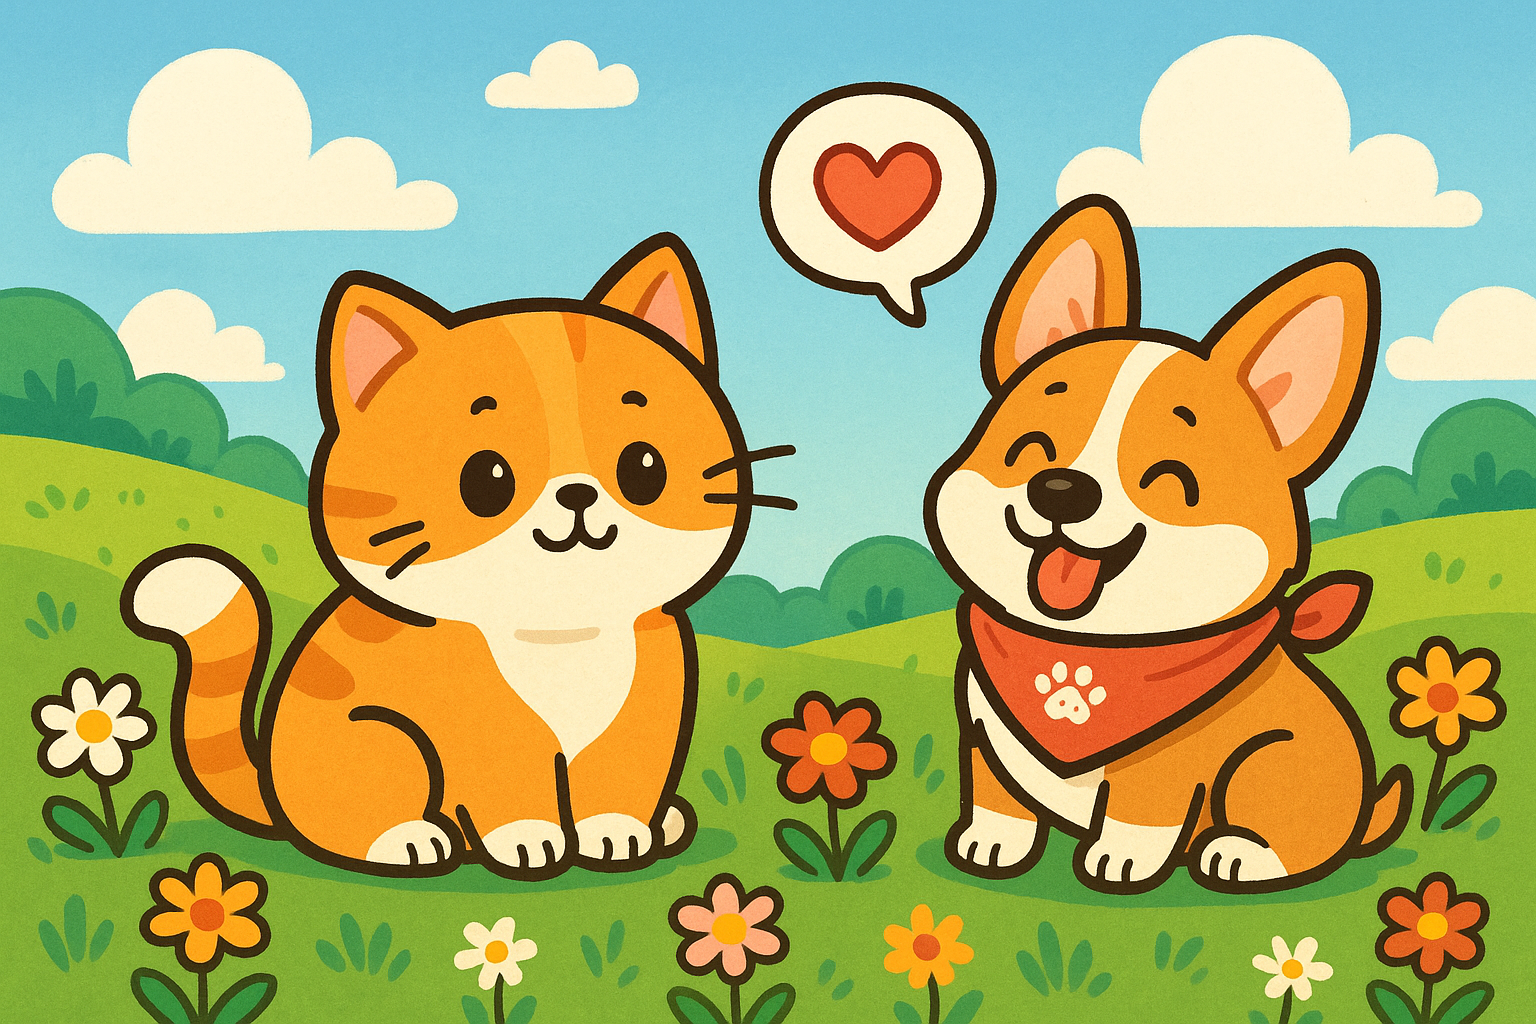

  Image displayed: ./outputs/synthetic_20251203_020919.png

WORKFLOW COMPLETED

✓ Final image saved at: ./outputs/synthetic_20251203_020919.png
  Final synthetic score: 9.0
  Final image score: 8.5


In [22]:
# Run the evaluator-optimizer workflow

config = {"configurable": {"thread_id": 1}}

print("\n" + "="*60)
print("STARTING EVALUATOR-OPTIMIZER WORKFLOW")
print("="*60)
print("\nThis workflow will:")
print("  1. Load images from ./images folder")
print("  2. Generate detailed prompts for each image")
print("  3. Create a composite prompt that blends all images")
print("  4. Evaluate the composite prompt (synthetic_score & image_score)")
print("  5. Iteratively refine until scores >= 8.0 (max 5 iterations)")
print("  6. Generate final synthetic image when scores are high enough")
print("="*60 + "\n")

# Execute the workflow
try:
    final_state = graph.invoke({}, config=config)
    
    print("\n" + "="*60)
    print("WORKFLOW COMPLETED")
    print("="*60)
    
    if final_state.get("final_image_path"):
        print(f"\n✓ Final image saved at: {final_state['final_image_path']}")
        print(f"  Final synthetic score: {final_state.get('synthetic_score', 'N/A')}")
        print(f"  Final image score: {final_state.get('image_score', 'N/A')}")
    else:
        print("\n⚠ No image was generated.")
        print(f"  Best synthetic score achieved: {final_state.get('best_synthetic_score', 'N/A')}")
        print(f"  Best image score achieved: {final_state.get('best_image_score', 'N/A')}")
        print(f"  Total iterations: {final_state.get('iteration', 0) + 1}")
    
except Exception as e:
    print(f"\n❌ Error during workflow execution: {e}")
    import traceback
    traceback.print_exc()


# Evaluator-Optimizer Workflow for Image Prompt Generation

This notebook implements an evaluator-optimizer workflow that:

1. **Loads images** from `./images` folder (supports variable number of images)
2. **Generates detailed visual prompts** for each image using GPT-4o-mini vision
3. **Creates a composite prompt** that synthesizes all input images
4. **Evaluates** the composite prompt with two scores:
   - `synthetic_score` (0-10): How well it blends all input images
   - `image_score` (0-10): How suitable it is for image generation
5. **Iteratively refines** the prompts using feedback (max 5 iterations)
6. **Generates final image** using `gpt-image-1` when scores ≥ 8.0

## Usage

1. Place your input images in the `./images` folder (supports .jpg, .jpeg, .png, .gif, .bmp, .webp)
2. Run all cells in order
3. The workflow will automatically iterate until scores meet the threshold or max iterations are reached
4. The final synthetic image will be saved to `./outputs/synthetic_<timestamp>.png`

## Workflow Architecture

The workflow is built using **LangGraph** with the following structure:

- **Nodes**: Each step is a node (load, generate, evaluate, etc.)
- **Conditional Edges**: The evaluator decides whether to continue iterating or generate the final image
- **State Management**: All data flows through a TypedDict State object
- **Iterative Loop**: The optimizer loop is modeled as a graph cycle

This makes the evaluator-optimizer pattern explicit and easy to understand.
